this is a notebook for speech siamese. 
the goal is to add siamese network after the speech command network to make a one-shot speech command model. with this model, take two piece of audio as input, the model will tell if it is the same speech command or not. 
if the accuracy is good enough, we make take it input product for voice trigger or voice command which are useful for all kind of product. 

the trick may be if siamese can make one shot accure enough. 

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import hashlib
import math, time, datetime
import os.path
import random
import re
import sys
import tarfile

#print(sys.executable)
import matplotlib.pyplot as plt
import numpy as np
import librosa as rosa
import librosa.display
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
from sklearn import preprocessing #copy from echo 1110/2018

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda, BatchNormalization, Activation, LSTM, GRU, concatenate
#from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
#from tensorflow.python.ops import io_ops
#from tensorflow.python.platform import gfile
#from tensorflow.python.util import compat

default_number_of_mfcc=128
default_sample_rate=16000
default_hop_length=512 
default_wav_duration=1 # 1 second
default_train_samples=10000
default_test_samples=100
default_epochs=10
default_batch_size=1024
default_train_wanted_words=["one", "two",  "backward", "bird", "cat", "dog", "five", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree",  "wow", "zero","up"]
default_test_wanted_words=["bed", "eight", "visual", "follow"]
#for mac
#speech_data_dir="/Users/hermitwang/Downloads/speech_dataset"
#default_model_path="/Users/hermitwang/Downloads/pretrained/speech_siamese"
#for ubuntu
#speech_data_dir="/home/hermitwang/TrainingData/datasets/speech_dataset"
##default_model_path="/home/hermitwang/TrainingData/pretrained/speech_siamese"
#default_processed_data_path="/home/hermitwang/TrainingData/pretrained/speech_siamese"
#for windows of work
#speech_data_dir="D:\\HermitWang\\DeepLearning\\dataset\\speech_dataset"
#default_model_path="D:\\HermitWang\\DeepLearning\\dataset\\trained\\siamese"
#for himl 
speech_data_dir="/home/hermitwang/Projects/datasets/speech_dataset"
default_model_path="/home/hermitwang/Projects/pretrained/speech_siamese"
default_processed_data_path="/home/hermitwang/Projects/pretrained/speech_siamese"

# One shot keyword trigger


Here is another implementation of one-shot learning of keyword trigger with librosa mfcc. 
librosa cannot put into tensorflow graph. so mfcc computation will be done before conv network. 
that means load_wav_mfcc has to convert all wav file to mfcc vector. 
Here i have to understand
    1, what is the good mfcc vector dimension. 20, 127 may not be the right input for conv network. 
    2, even the mfcc output of librosa is not the same as tensorflow contrib.decode wav, it is enough if it has all audio feature. put librosa mfcc output as input of conv net, it will do good learning about feature abstraction. 
    3, conv net may not be that difficult. just like conv2d -> maxpooling -> conv2d->flatten->dense with softmax. 
    4, build the train network with librosa and conv net.
    5, take the dense vector output as feature extractor. 
    6, build siamese network with the feature extractor. 
    7, may add couples of dense layer to learn the feature mapping and comparation of siamese. 
    8, if that works, we get an one-shot learning for key word trigger...
    9, in reality, we still have to work out how to split the audio stream into audio clip as the input the librosa mfcc.
    

### MFCC 

extract MFCC from wav file
what is the wav parameter for MFCC output

tensorflow speech command parameter 
{'desired_samples': 16000, 'window_size_samples': 480, 'window_stride_samples': 160, 'spectrogram_length': 98, 'fingerprint_width': 40, 'fingerprint_size': 3920, 'label_count': 12, 'sample_rate': 16000, 'preprocess': 'mfcc', 'average_window_width': -1}

Mel-frequency cepstral coefficients (MFCCs)
Parameters:	
y:np.ndarray [shape=(n,)] or None
audio time series
sr:number > 0 [scalar]
sampling rate of y
S:np.ndarray [shape=(d, t)] or None
log-power Mel spectrogram
n_mfcc: int > 0 [scalar]
number of MFCCs to return
Returns:	
M:np.ndarray [shape=(n_mfcc, t)]
MFCC sequence

need more study about MFCC output


## How to calculate the lenght of mfcc vector
Short Answer

You can specify the change the length by changing the parameters used in the stft calculations. The following code will double the size of your output (20 x 113658)

data = librosa.feature.mfcc(y=y, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)
Long Answer

Librosa's librosa.feature.mfcc() function really just acts as a wrapper to librosa's librosa.feature.melspectrogram() function (which is a wrapper to librosa.core.stft and librosa.filters.mel functions).

All of the parameters pertaining to segementation of the audio signal - namely the frame and overlap values - are specified utilized in the Mel-scaled power spectrogram function (with other tune-able parameters specified for nested core functions). You specify these parameters as keyword arguments in the librosa.feature.mfcc() function.

All extra **kwargs parameters are fed to librosa.feature.melspectrogram() and subsequently to librosa.filters.mel()

By Default, the Mel-scaled power spectrogram window and hop length are the following:

n_fft=2048

hop_length=512

So assuming you used the default sample rate (sr=22050), the output of your mfcc function makes sense:

output length = (seconds) * (sample rate) / (hop_length)

(1319) * (22050) / (512) = 56804 samples


the mfcc vector size is 128 * 32   

1 * 16000/512 = 31.25 = 32 

(32, 128)
(32, 128)


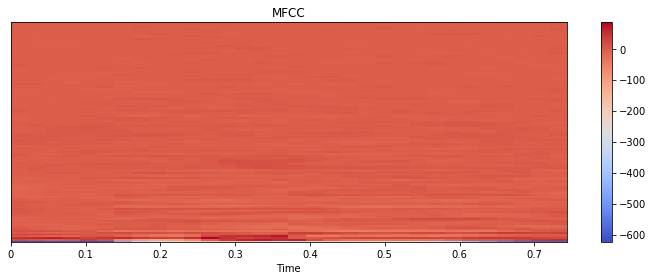

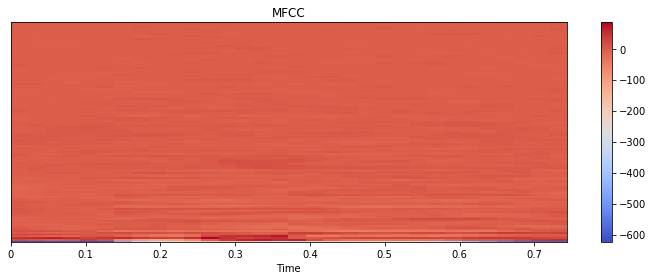

In [4]:
def load_wav_mfcc(filename):
    wav_loader, sample_rate = rosa.load(filename, sr=default_sample_rate)
    #print(rosa.get_duration(wav_loader, sample_rate))
    wav_mfcc = rosa.feature.mfcc(y=wav_loader, sr=default_sample_rate, n_mfcc=default_number_of_mfcc)
    wav_mfcc = np.transpose(wav_mfcc)
    return wav_mfcc

def get_default_mfcc_length(default_wav_duration=1):
    length = int(math.ceil(default_wav_duration * default_sample_rate / default_hop_length))
    return length

def mfcc_display(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
wav_mfcc_data = load_wav_mfcc(speech_data_dir + "/six/ffd2ba2f_nohash_3.wav")
print(wav_mfcc_data.shape)
mfcc_display(np.transpose(wav_mfcc_data))

wav_mfcc_data = load_wav_mfcc(speech_data_dir + "/six/ffd2ba2f_nohash_3.wav") #""/five/56eab10e_nohash_0.wav")
print(wav_mfcc_data.shape)
mfcc_display(np.transpose(wav_mfcc_data))

# Wav MFCC loader
Wav file loader and export mfcc sequence. 

0, go throught all wav file to add background voice into command wav file
1, go through all wav file and convert to MFCC sequence
2, construct pair of MFCC sequence and a target (0 or 1, 0 for different command, 1 for the same command)
    the same word * 1000, random generate key index, the first index of wav, and the second index of wav. 
    the diff word * 1000, random generae two key index, the first index of wav, and the second index of wav. 
    the format will be [mfcc 1, mfcc 2, 0/1 for the same or different]
3, prepare pair of MFCC and targets according to batch size.  

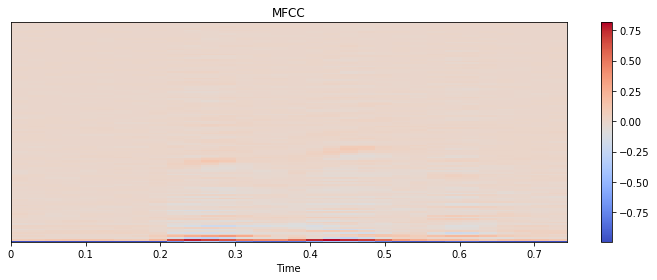

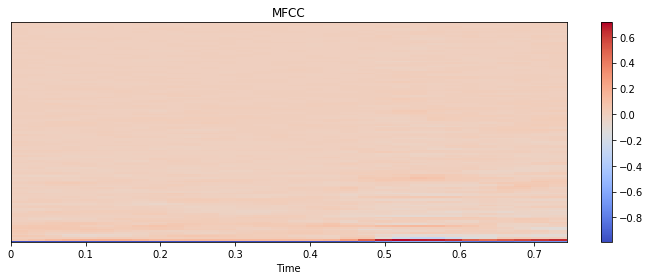

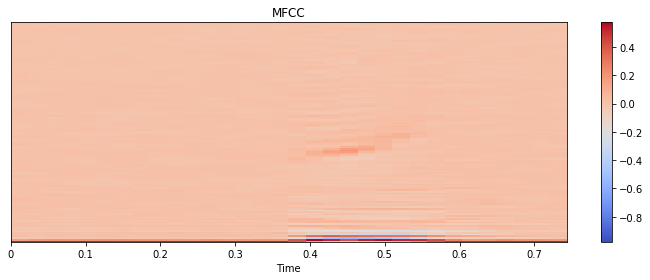

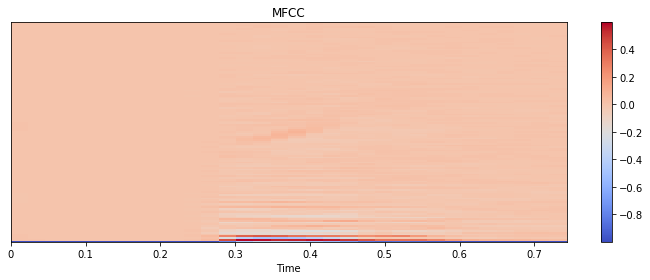

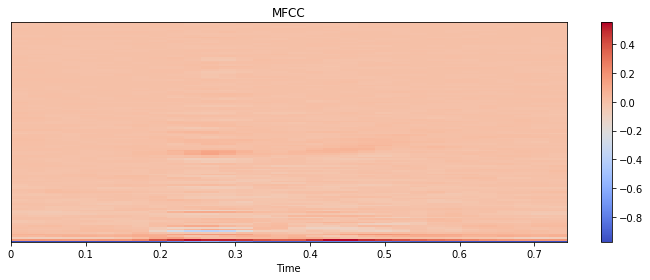

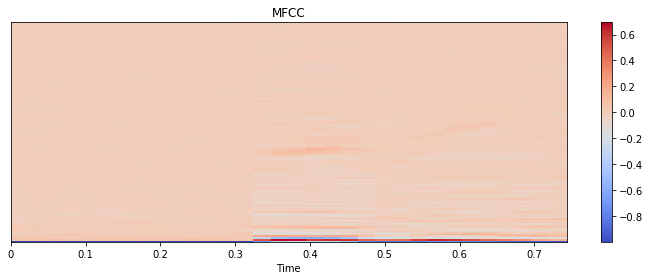

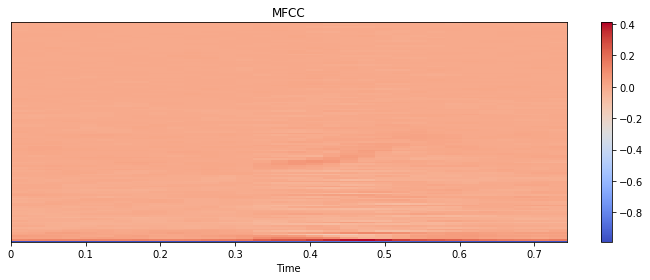

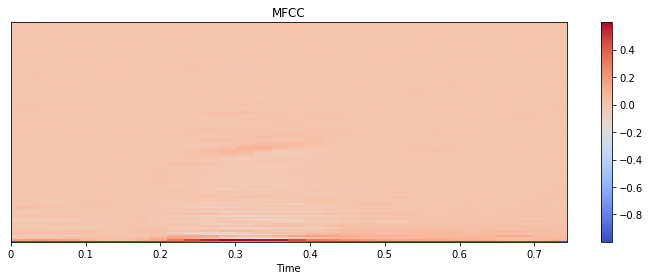

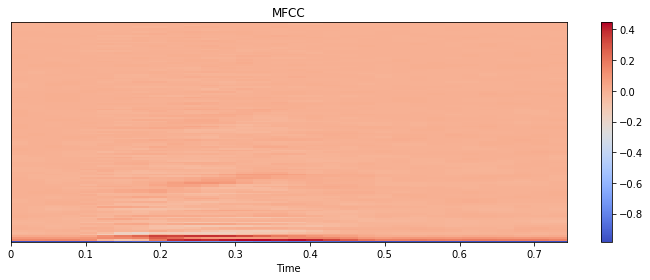

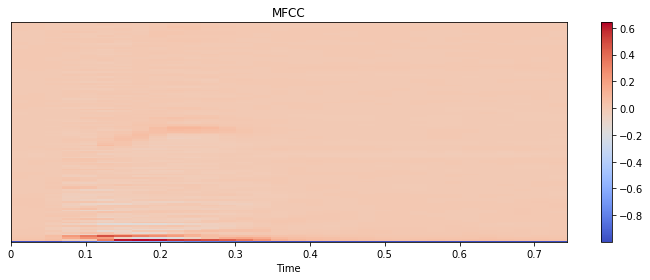

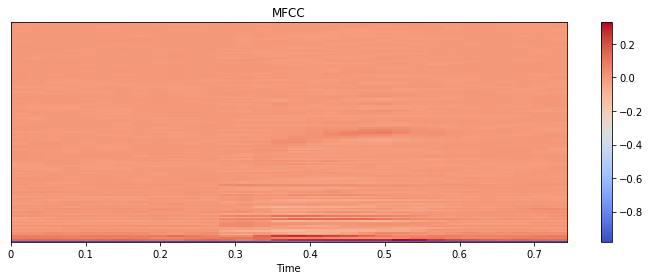

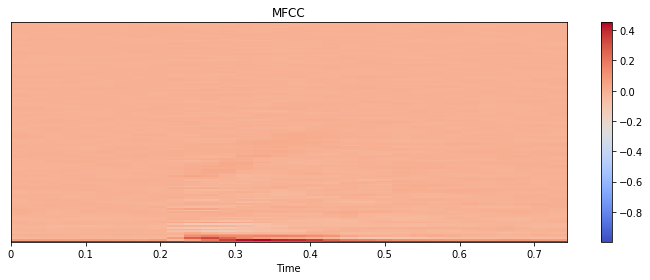

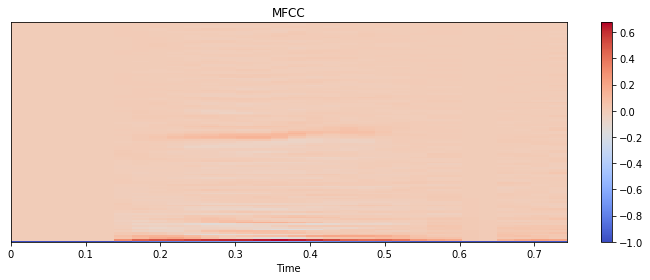

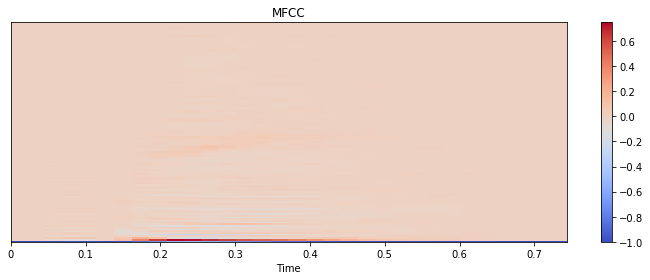

In [5]:
class WavMFCCLoader(object):
    def __init__(self, data_dir, wanted, validation_percentage=0, testing_percentage=0):
        self.data_dir = data_dir
        self.wanted = wanted
        self.default_mfcc_length=get_default_mfcc_length(default_wav_duration)
        self.wav_files = dict()
        self.wav_file_index()
        self.mfccs_mean = 0
        self.mfccs_std = 0
        
        
    def wav_file_index(self):
        for dirpath, dirnames, files in os.walk(self.data_dir):
            for name in files:
                if name.lower().endswith('.wav'):
                    #for windows
                    #word_name = dirpath.rsplit('\\', 1)[1];
                    #for others
                    word_name = dirpath.rsplit('/', 1)[1];
                    if word_name in self.wanted:
                        file_name = os.path.join(dirpath, name)
                        #print(file_name, dirpath, word_name)
    
                        if word_name in self.wav_files.keys():
                            self.wav_files[word_name].append(file_name)
                        else:
                            self.wav_files[word_name] = [file_name]
                    
        return self.wav_files


    def wavs_to_mfcc_pair(self):
        how_many_words = len(self.wanted)
        a_index = random.randint(0, how_many_words - 1)
        b_index = random.randint(0, how_many_words - 1)
        a_wav_index = b_wav_index = -1
        mfcc_pair = np.array([3, 1])
        if (a_index > b_index):
            a_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(self.wav_files[self.wanted[b_index]]) - 1)
            mfcc_1 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(self.wav_files[self.wanted[b_index]][b_wav_index])
            mfcc_pair = 0            
        else:
            a_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            mfcc_1 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][b_wav_index])
            mfcc_pair = 1
            
        #print("aaa", mfcc_1.shape, mfcc_2.shape)    
        return mfcc_1, mfcc_2, mfcc_pair
        
    def get_mfcc_pairs(self, how_many, preprocess='global'):
        mfcc1_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        mfcc2_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        same_data = np.zeros(how_many)
        for i in range(how_many):
            
            mfcc1_data_, mfcc2_data_, same_data[i] = self.wavs_to_mfcc_pair()
            
            
            if preprocess == "global":
                get_sample_mean_std()
                mfcc1_data_ = (mfcc1_data_ - self.mfccs_mean[0:mfcc1_data_.shape[0], :]) / self.mfccs_std[0:mfcc1_data_.shape[0], :]
                mfcc2_data_ = (mfcc2_data_ - self.mfccs_mean[0:mfcc2_data_.shape[0], :]) / self.mfccs_std[0:mfcc2_data_.shape[0], :]
            elif preprocess == "z-score":
                mfcc1_data_ = preprocessing.scale(mfcc1_data_)
                mfcc2_data_ = preprocessing.scale(mfcc2_data_)               
            elif preprocess == "max-min-scaler":
                mfcc1_data_ = preprocessing.MinMaxScaler().fit_transform(mfcc1_data_)
                mfcc2_data_ = preprocessing.MinMaxScaler().fit_transform(mfcc2_data_)
            elif preprocess == "l2-normalize":
                mfcc1_data_ = preprocessing.normalize(mfcc1_data_, norm='l2')
                mfcc2_data_ = preprocessing.normalize(mfcc2_data_, norm='l2')
            else:
                raise ValueError("unknown proprocess")
            
            
            mfcc1_data[i, 0:mfcc1_data_.shape[0], : ] = mfcc1_data_
            mfcc2_data[i, 0:mfcc2_data_.shape[0], : ] = mfcc2_data_
            #np.append(mfcc1_data, mfcc1_)
            #np.append(mfcc2_data, mfcc2_)
            #np.append(same_data, same_)          
        #print(mfcc_pairs)
    
        return mfcc1_data, mfcc2_data, same_data
    
    def get_sample_mean_std(self):
        count = 0
        for i in (self.wanted):
            #print(i)
            for j in range(len(self.wav_files[i])):
                #print(self.wav_files[i][j])
                count += 1
        #print("count:", count)
        mfccs = np.zeros((count, self.default_mfcc_length, default_number_of_mfcc))
        index = 0
        for i in (self.wanted):
            for j in range(len(self.wav_files[i])):       
                mfcc_ = load_wav_mfcc(self.wav_files[i][j])
                mfccs[index, 0:mfcc_.shape[0], : ] = mfcc_
                index += 1
        self.mfccs_mean = mfccs.mean(0)
        self.mfccs_std = mfccs.std(0)
        

#loader = WavMFCCLoader(speech_data_dir, wanted=["one", "two", "bed", "backward", "bird", "cat", "dog", "eight", "five", "follow", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero"])
loader = WavMFCCLoader(speech_data_dir, wanted=["one", "two", "bed", "backward"])
#wav_list = loader.wav_file_index()
mfcc1_data, mfcc2_data, same_pair = loader.get_mfcc_pairs(10, preprocess='l2-normalize')
for i in range( len(same_pair)):
    if (same_pair[i]):
        mfcc_display(np.transpose(mfcc1_data[i]))
        mfcc_display(np.transpose(mfcc2_data[i]))
        

## Data loader for training and testing 

In [6]:

def read_data_file(file_name):
    f = open(file_name, "rb")
    t = np.load(f)
    print("shape:", t.shape)
    f.close()
    return t

def write_data_file(file_name, data):
    f = open(file_name, "wb")
    np.save(f, data)
    f.close()
    

def store_processed_data(local_train_samples=default_train_samples, local_test_samples=default_test_samples, local_process_data_path=default_processed_data_path, local_preprocess='l2-normalize', local_train_wanted=default_train_wanted_words, local_test_wanted=default_test_wanted_words):
    train_loader = WavMFCCLoader(speech_data_dir, wanted=local_train_wanted)
    mfcc1_train_data, mfcc2_train_data, train_pairs = train_loader.get_mfcc_pairs(local_train_samples, preprocess=local_preprocess)
    mfcc1_eval_data, mfcc2_eval_data, eval_pairs = train_loader.get_mfcc_pairs(local_test_samples, preprocess=local_preprocess)

    test_loader  = WavMFCCLoader(speech_data_dir, wanted=local_test_wanted)
    mfcc1_test_data, mfcc2_test_data, test_pairs = test_loader.get_mfcc_pairs(local_test_samples, preprocess=local_preprocess)

    #store the training mfcc1 data to np file
    filename_train_mfcc1 = local_process_data_path + "/mfcc1_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_mfcc1, mfcc1_train_data)
    
    #store the training mfcc2 data to np file
    filename_train_mfcc2 = local_process_data_path + "/mfcc2_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_mfcc2, mfcc2_train_data)
    
    #store the training pair data to np file
    filename_train_pairs = local_process_data_path + "/pairs_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_pairs, train_pairs)
    

    #store the eval mfcc1 data to np file
    filename_eval_mfcc1 = local_process_data_path + "/mfcc1_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_mfcc1, mfcc1_eval_data)
    
    
    #store the eval mfcc2 data to np file
    filename_eval_mfcc2 = local_process_data_path + "/mfcc2_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_mfcc2, mfcc2_eval_data)
    
    
    #store the eval pair data to np file
    filename_eval_pairs = local_process_data_path + "/pairs_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_pairs, eval_pairs)
    
    
    
    #store the test mfcc1 data to np file
    filename_test_mfcc1 = local_process_data_path + "/mfcc1_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_mfcc1, mfcc1_test_data)
    
    
    #store the test mfcc2 data to np file
    filename_test_mfcc2 = local_process_data_path + "/mfcc2_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_mfcc2, mfcc2_test_data)
    
    
    #store the test pair data to np file
    filename_test_pairs = local_process_data_path + "/pairs_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_pairs, test_pairs)
    
    
    
def load_processed_data(local_train_samples=default_train_samples, local_test_samples=default_test_samples, local_process_data_path=default_processed_data_path, local_preprocess='l2-normalize'):
    
    filename_train_mfcc1 = local_process_data_path + "/mfcc1_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"    
    
    if not (os.path.isfile(filename_train_mfcc1)):
        store_processed_data(local_train_samples, local_test_samples, local_process_data_path, local_preprocess)
    
    filename_train_mfcc1 = local_process_data_path + "/mfcc1_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    mfcc1_train_data = read_data_file(filename_train_mfcc1)
    filename_train_mfcc2 = local_process_data_path + "/mfcc2_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    mfcc2_train_data = read_data_file(filename_train_mfcc2)
    filename_train_pairs = local_process_data_path + "/pairs_train_" + str(local_train_samples) + "_" + local_preprocess + ".npy"
    train_pairs = read_data_file(filename_train_pairs)
    filename_eval_mfcc1 = local_process_data_path + "/mfcc1_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc1_eval_data = read_data_file(filename_eval_mfcc1)
    filename_eval_mfcc2 = local_process_data_path + "/mfcc2_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc2_eval_data = read_data_file(filename_eval_mfcc2)
    filename_eval_pairs = local_process_data_path + "/pairs_eval_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    eval_pairs = read_data_file(filename_eval_pairs)
    filename_test_mfcc1 = local_process_data_path + "/mfcc1_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc1_test_data = read_data_file(filename_test_mfcc1)
    filename_test_mfcc2 = local_process_data_path + "/mfcc2_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc2_test_data = read_data_file(filename_test_mfcc2)
    filename_test_pairs = local_process_data_path + "/pairs_test_" + str(local_test_samples) + "_" + local_preprocess + ".npy"
    test_pairs = read_data_file(filename_test_pairs)    
    
    return mfcc1_train_data, mfcc2_train_data, train_pairs, mfcc1_eval_data, mfcc2_eval_data, eval_pairs, mfcc1_test_data, mfcc2_test_data, test_pairs
    

# LSTM Network

create a keras lstm network, take mfcc vector as input.

the speech command mfcc input shape is (?, mfcc_number, hop_number, 1)




In [7]:
def create_lstm_model(local_input_shape, is_training=True):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=local_input_shape))
    model.add(GRU(1024, return_sequences=False, stateful=False, input_shape=local_input_shape))
    #model.add(GRU(256, return_sequences=True, stateful=False))
    #model.add(GRU(256, stateful=False))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid")) 
    #if (is_training):
    #    model.add(Dropout(0.5))
    #model.add(Dense(labels_count, activation="softmax"))
    
    return model


In [8]:
def create_siamese_model(input_shape, siamese_mode = 'concat'):
    right_input = Input(input_shape)
    left_input = Input(input_shape)
    keras_model = create_lstm_model(input_shape)
    
    right_encoder = keras_model(right_input)
    left_encoder = keras_model(left_input)
    if (siamese_mode == 'minus'):
        concatenated_layer = Lambda(lambda x: x[0]-x[1], output_shape=lambda x: x[0])([right_encoder, left_encoder])
    elif (siamese_mode == 'abs'):
        concatenated_layer = Lambda(lambda x: tf.abs(x[0]-x[1]), output_shape=lambda x: x[0])([right_encoder, left_encoder])
    elif (siamese_mode == "concat"):
        concatenated_layer = concatenate(inputs=[right_encoder, left_encoder])
    else:
        raise ValueError("unknown siamese_mode")
        
    last_layer = Dense(1024, activation='relu')(concatenated_layer)
    output_layer = Dense(1, activation='sigmoid')(last_layer)
    
    siamese_model = Model([right_input, left_input], output_layer)
    return siamese_model
    
def siamese_train(mfcc1_train_data, mfcc2_train_data, train_pairs, mfcc1_eval_data, mfcc2_eval_data, eval_pairs, local_siamese_mode='concat', local_batch_size=default_batch_size, local_epochs= default_epochs):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)
    siamese_model = create_siamese_model((default_mfcc_length, default_number_of_mfcc), siamese_mode=local_siamese_mode)

    siamese_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    x1_train = mfcc1_train_data #.reshape((train_samples, default_mfcc_length, default_number_of_mfcc)) #hop length is the time feature
    x2_train = mfcc2_train_data #.reshape((train_samples, default_mfcc_length, default_number_of_mfcc)) #mfcc_number is the data feature
    y_train = train_pairs  #keras.utils.to_categorical(pairs, num_classes=1)
    
    
    siamese_model.fit([x1_train, x2_train], y_train, epochs=local_epochs, batch_size=local_batch_size)
    
    
    x1_test = mfcc1_eval_data #.reshape((default_test_samples, default_mfcc_length, default_number_of_mfcc))
    x2_test = mfcc2_eval_data #.reshape((default_test_samples, default_mfcc_length, default_number_of_mfcc))
    y_test = eval_pairs
    
    loss, accuracy = siamese_model.evaluate([x1_test, x2_test], y_test)    
    
    siamese_model.save(default_model_path+"/speech_siamese.h5")

    print(loss)
    return accuracy

def siamese_test(mfcc1_test_data, mfcc2_test_data, test_pairs):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)    
    siamese_model = keras.models.load_model(default_model_path+"/speech_siamese.h5")    
    x1_test = mfcc1_test_data #.reshape((test_samples, default_mfcc_length, default_number_of_mfcc))
    x2_test = mfcc2_test_data #.reshape((test_samples, default_mfcc_length, default_number_of_mfcc))
    y_test = test_pairs
    
    loss, accuracy = siamese_model.test_on_batch(x=[x1_test, x2_test], y=y_test)
    print(loss)
    return accuracy

## main 

In [ ]:
#wav_mfcc = load_wav_mfcc("/Users/hermitwang/Downloads/speech_dataset/backward/0a2b400e_nohash_0.wav")
#print(wav_mfcc.shape) 
train_samples = default_train_samples * 5
test_samples = default_test_samples
batch_size_numbers=[128, 256, 512, 1024, 2048]
train_epochs = 30
print("Start at " + str(datetime.datetime.now()))
mfcc1_train_data, mfcc2_train_data, train_pairs, mfcc1_eval_data, mfcc2_eval_data, eval_pairs, mfcc1_test_data, mfcc2_test_data, test_pairs = load_processed_data(local_train_samples=train_samples, local_test_samples=test_samples, local_preprocess='z-score')

for i in range(5):
    for j in range(4, 5):
        print("Train batch size " + str(batch_size_numbers[j]) + " of " + str(i+1) + " run start at " + str(datetime.datetime.now()) + ":")
        score=siamese_train(mfcc1_train_data, mfcc2_train_data, train_pairs, mfcc1_eval_data, mfcc2_eval_data, eval_pairs, local_siamese_mode='abs', local_batch_size=batch_size_numbers[j], local_epochs=train_epochs)
        print(score)
        score=siamese_test(mfcc1_test_data, mfcc2_test_data, test_pairs)
    
        print(score)

Start at 2018-11-11 14:10:46.626362
shape: (50000, 32, 128)
shape: (50000, 32, 128)
shape: (50000,)
shape: (100, 32, 128)
shape: (100, 32, 128)
shape: (100,)
shape: (100, 32, 128)
shape: (100, 32, 128)
shape: (100,)
Train batch size 2048 of 1 run start at 2018-11-11 14:11:03.685997:
Epoch 1/30
50000/50000 [==============================] - 45s 897us/step - loss: 0.9945 - acc: 0.5179
Epoch 2/30
50000/50000 [==============================] - 40s 793us/step - loss: 0.6901 - acc: 0.5468
Epoch 3/30
50000/50000 [==============================] - 40s 795us/step - loss: 0.6925 - acc: 0.5214
Epoch 4/30
50000/50000 [==============================] - 40s 797us/step - loss: 0.7088 - acc: 0.5297
Epoch 5/30
50000/50000 [==============================] - 40s 797us/step - loss: 0.7096 - acc: 0.5244
Epoch 6/30
50000/50000 [==============================] - 40s 795us/step - loss: 0.7041 - acc: 0.5198
Epoch 7/30
50000/50000 [==============================] - 40s 795us/step - loss: 0.7003 - acc: 0.5071
Ep

50000/50000 [==============================] - 42s 836us/step - loss: 0.6670 - acc: 0.5831
Epoch 15/30
50000/50000 [==============================] - 42s 837us/step - loss: 0.6633 - acc: 0.5832
Epoch 16/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.6553 - acc: 0.5972
Epoch 17/30
50000/50000 [==============================] - 42s 834us/step - loss: 0.6453 - acc: 0.6054
Epoch 18/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.6402 - acc: 0.6137
Epoch 19/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.6317 - acc: 0.6205
Epoch 20/30
50000/50000 [==============================] - 42s 835us/step - loss: 0.6276 - acc: 0.6242
Epoch 21/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.6153 - acc: 0.6352
Epoch 22/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.6044 - acc: 0.6487
Epoch 23/30
50000/50000 [==============================] - 42s 836us/step - loss: 0.5

# the fact


